### importing the necessary packages

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
import os

num_classes = 10
img_rows, img_cols = 224, 224
batch_size = 16

Using TensorFlow backend.


### image augmentation

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = './flowers/train'
validation_data_dir = './flowers/validation'

# data augmentation 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 699 images belonging to 10 classes.
Found 99 images belonging to 10 classes.


### defining our model

In [3]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 64)     

### plotting our model

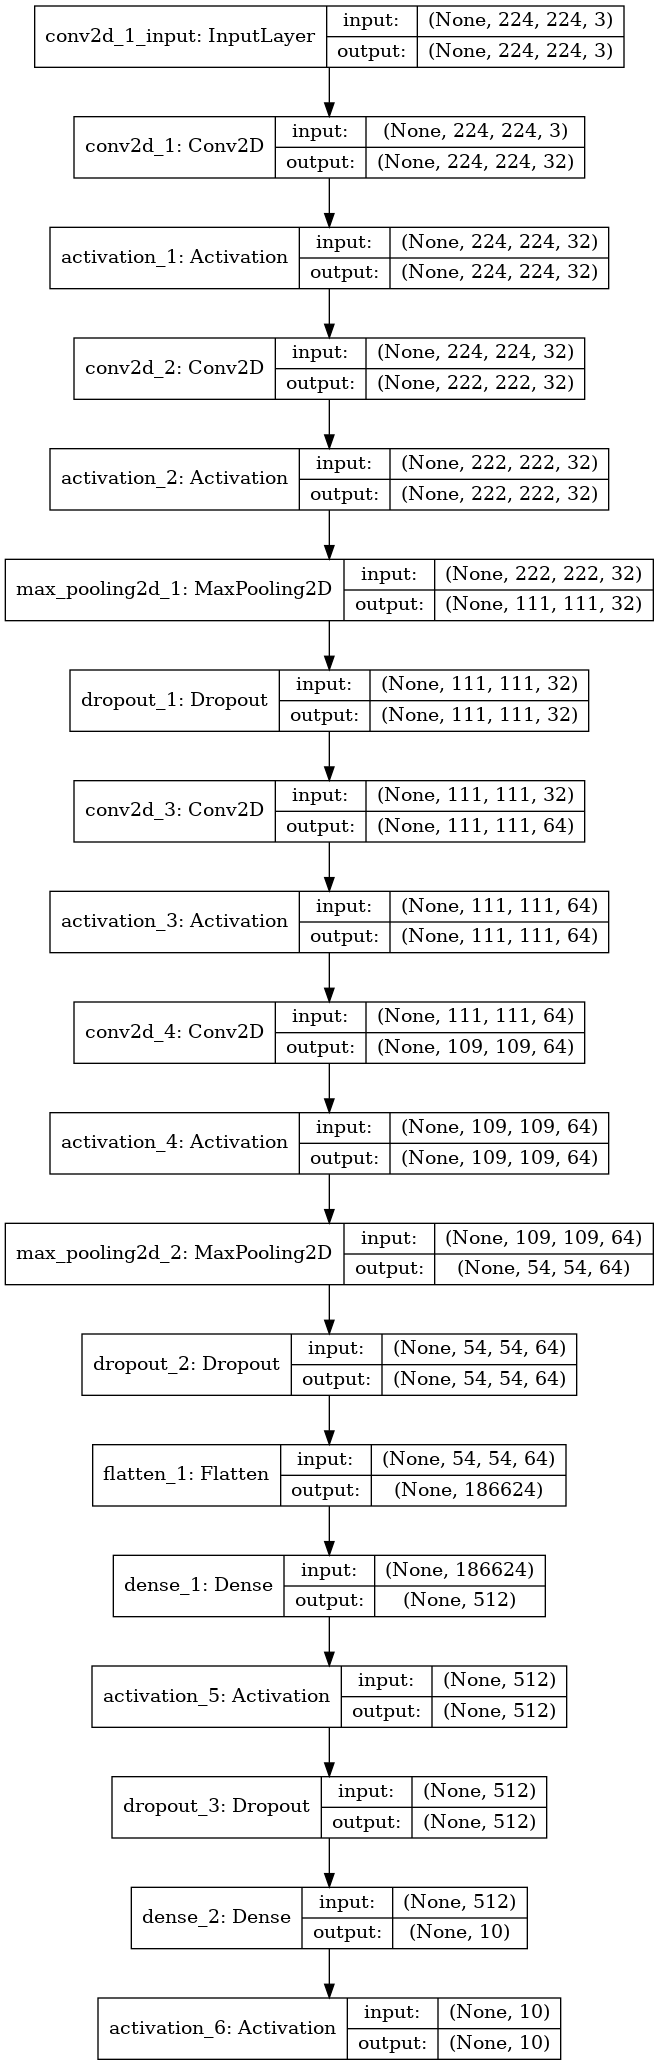

In [4]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### initializing the callbacks

In [6]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("./flowers_cnn_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

### compiling our model

In [7]:
# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 699
nb_validation_samples = 99
epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
43/43 [==============================] - 313s 7s/step - loss: 8.7659 - accuracy: 0.1040 - val_loss: 2.3058 - val_accuracy: 0.0938

Epoch 00001: val_loss improved from inf to 2.30580, saving model to /home/mayank/Desktop/folder/flowers_cnn_1.h5
Epoch 2/10
43/43 [==============================] - 326s 8s/step - loss: 2.3548 - accuracy: 0.1127 - val_loss: 2.3033 - val_accuracy: 0.0602

Epoch 00002: val_loss improved from 2.30580 to 2.30334, saving model to /home/mayank/Desktop/folder/flowers_cnn_1.h5
Epoch 3/10
43/43 [==============================] - 367s 9s/step - loss: 2.3667 - accuracy: 0.1654 - val_loss: 2.0527 - val_accuracy: 0.2771

Epoch 00003: val_loss improved from 2.30334 to 2.05273, saving model to /home/mayank/Desktop/folder/flowers_cnn_1.h5
Epoch 4/10
43/43 [==============================] - 343s 8s/step - loss: 2.1301 - accuracy: 0.1846 - val_loss: 1.9384 - val_accuracy: 0.3253

Epoch 00004: val_loss improved from 2.05273 to 1.93840, saving model to /home/mayank/

### displaying our confusion matrix

Confusion Matrix


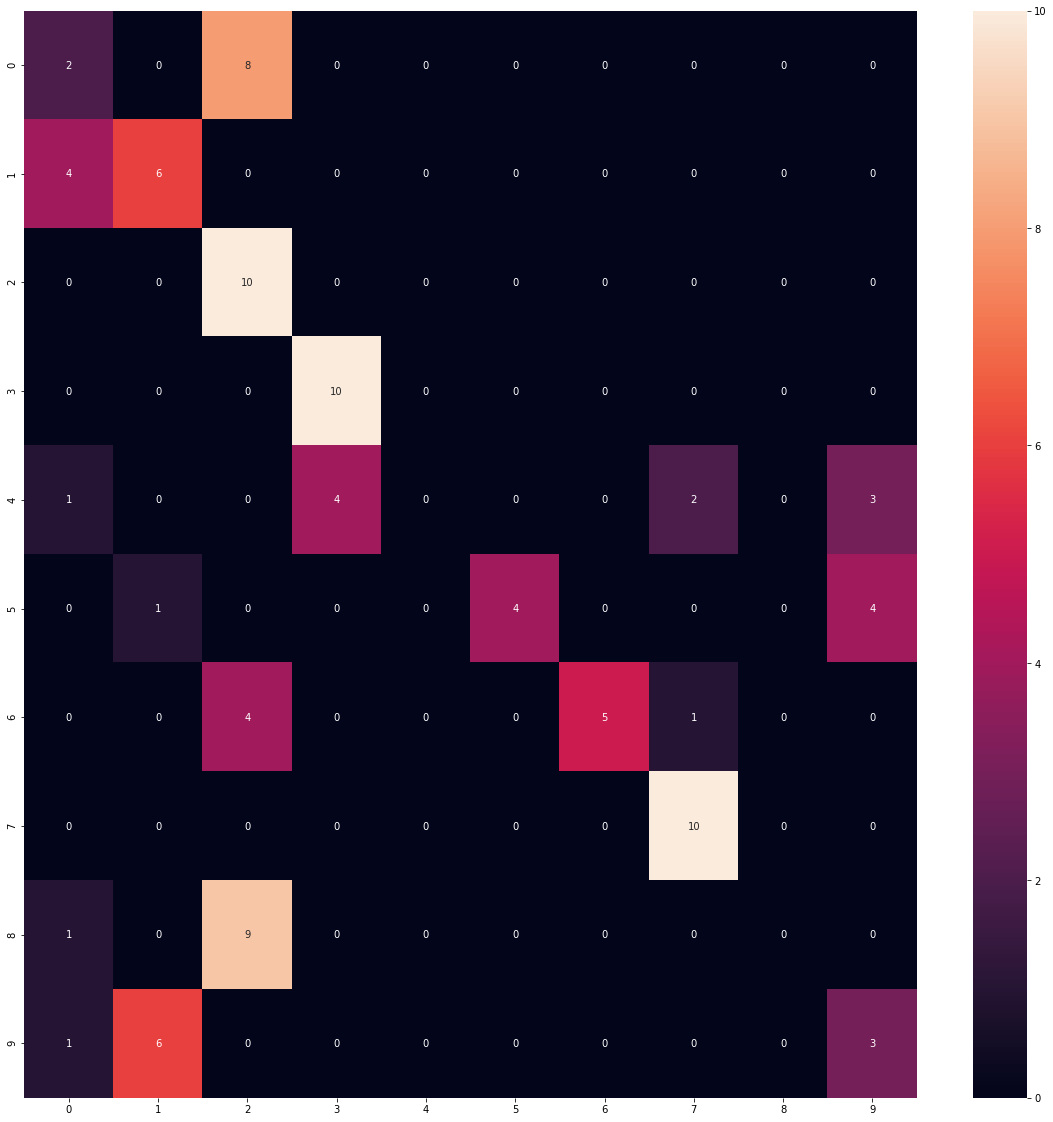

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#Confusion Matrix
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(validation_generator.classes, y_pred),annot=True)

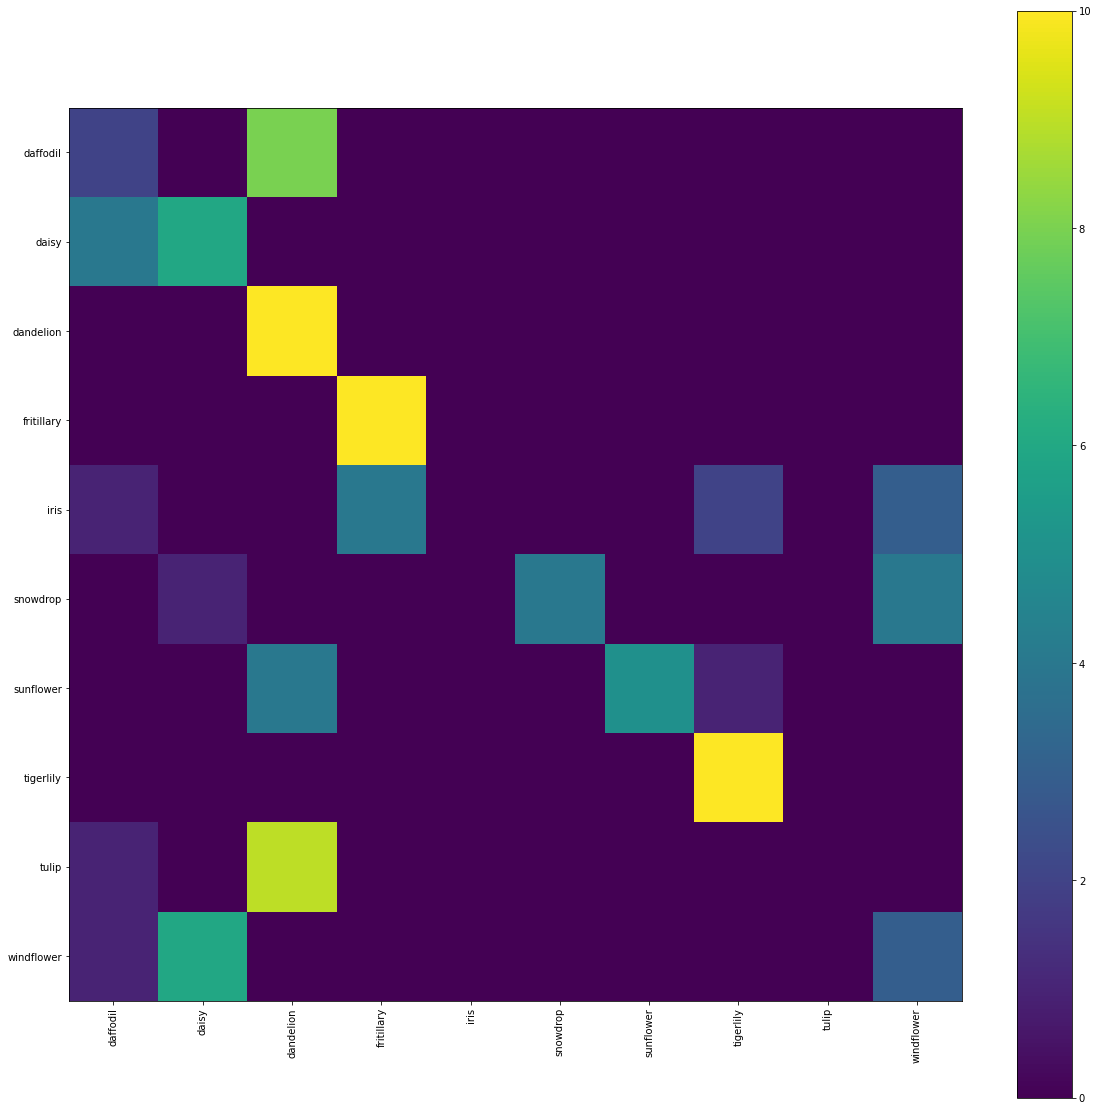

In [10]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 224,224,3
model = load_model("./flowers_cnn_1.h5")

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 699
nb_validation_samples = 99

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)